In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "16g")\
    .getOrCreate()

spark

In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import multiprocessing.pool
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from cycler import cycler
from pyspark.sql.functions import col, lit

from common import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_colwidth', None)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
THRP_PREFIX = "main/scale/ycsb"

IGNORE_CACHE = False

thrp_index_df = from_cache_or_compute(
    f'{THRP_PREFIX}/index.parquet',
    lambda: get_index(spark, THRP_PREFIX).toPandas().convert_dtypes().astype({
        "wl:hot": "int32",
        "wl:mh": "int32",
        "wl:mp": "int32"
    }),
    ignore_cache=IGNORE_CACHE,
)
thrp_index_df

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:mh,...,wl:hot_records,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home
0,file:/home/ctring/data/detock/main/scale/ycsb/baseline-sz15-hot10000mh5mp0,1.0.1075,baseline-15.conf,30,2000000,10000,45000,10,basic,5,...,2,1,2,10000,100,2,10,1,-1,-1
1,file:/home/ctring/data/detock/main/scale/ycsb/baseline-sz11-hot10000mh0mp0,1.0.1075,baseline-11.conf,30,2000000,0,35000,10,basic,0,...,2,1,2,10000,100,2,10,1,-1,-1
2,file:/home/ctring/data/detock/main/scale/ycsb/baseline-sz11-hot10000mh5mp5,1.0.1075,baseline-11.conf,30,2000000,0,35000,10,basic,5,...,2,1,2,10000,100,2,10,1,-1,-1
3,file:/home/ctring/data/detock/main/scale/ycsb/baseline-sz15-hot10000mh5mp5,1.0.1075,baseline-15.conf,30,2000000,10000,45000,10,basic,5,...,2,1,2,10000,100,2,10,1,-1,-1
4,file:/home/ctring/data/detock/main/scale/ycsb/baseline-sz11-hot10000mh5mp0,1.0.1075,baseline-11.conf,30,2000000,0,35000,10,basic,5,...,2,1,2,10000,100,2,10,1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,file:/home/ctring/data/detock/main/scale/ycsb/ddr_ts-sz7-hot100mh5mp0,1.0.1075,ddr_ts-7.conf,30,2000000,0,25000,10,basic,5,...,2,1,2,100,100,2,10,1,-1,-1
116,file:/home/ctring/data/detock/main/scale/ycsb/ddr_ts-sz9-hot100mh5mp0,1.0.1075,ddr_ts-9.conf,30,2000000,0,30000,10,basic,5,...,2,1,2,100,100,2,10,1,-1,-1
117,file:/home/ctring/data/detock/main/scale/ycsb/ddr_ts-sz7-hot100mh5mp5,1.0.1075,ddr_ts-7.conf,30,2000000,0,25000,10,basic,5,...,2,1,2,100,100,2,10,1,-1,-1
118,file:/home/ctring/data/detock/main/scale/ycsb/ddr_ts-sz9-hot100mh5mp5,1.0.1075,ddr_ts-9.conf,30,2000000,0,30000,10,basic,5,...,2,1,2,100,100,2,10,1,-1,-1


In [7]:
IGNORE_CACHE = False

def compute_throughput(prefix):
    res = throughput2(
        spark,
        prefix
    ).first().throughput
    return res

def compute_all_throughputs(index_df):
    prefix = list(index_df["prefix"])

    # Compute the throughput of each prefix
    with multiprocessing.pool.ThreadPool() as pool:
        res = pool.map(compute_throughput, prefix)
    
    # Construct a dataframe from the results
    throughput_df = pd.DataFrame({"prefix": prefix, "throughput": res})

    # Add 'scale' column based on the size of the deployment
    throughput_df["scale"] = throughput_df.prefix.str.extract(r'sz(\d+)').astype('int32')

    # Associate metadata from the index to the throughputs
    return throughput_df.merge(index_df, on="prefix")

throughput_df = from_cache_or_compute(
    f'{THRP_PREFIX}/throughput.parquet',
    lambda: compute_all_throughputs(thrp_index_df),
    ignore_cache=IGNORE_CACHE,
)

throughput_df

,prefix,throughput,scale,version,config_name,duration,txns,clients,rate,sample,...,wl:hot_records,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home
0,file:/home/ctring/data/detock/main/scale/ycsb/baseline-sz15-hot10000mh5mp0,273496.992734,15,1.0.1075,baseline-15.conf,30,2000000,10000,45000,10,...,2,1,2,10000,100,2,10,1,-1,-1
1,file:/home/ctring/data/detock/main/scale/ycsb/baseline-sz11-hot10000mh0mp0,213684.475567,11,1.0.1075,baseline-11.conf,30,2000000,0,35000,10,...,2,1,2,10000,100,2,10,1,-1,-1
2,file:/home/ctring/data/detock/main/scale/ycsb/baseline-sz11-hot10000mh5mp5,212781.817502,11,1.0.1075,baseline-11.conf,30,2000000,0,35000,10,...,2,1,2,10000,100,2,10,1,-1,-1
3,file:/home/ctring/data/detock/main/scale/ycsb/baseline-sz15-hot10000mh5mp5,256033.670487,15,1.0.1075,baseline-15.conf,30,2000000,10000,45000,10,...,2,1,2,10000,100,2,10,1,-1,-1
4,file:/home/ctring/data/detock/main/scale/ycsb/baseline-sz11-hot10000mh5mp0,212762.540569,11,1.0.1075,baseline-11.conf,30,2000000,0,35000,10,...,2,1,2,10000,100,2,10,1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,file:/home/ctring/data/detock/main/scale/ycsb/ddr_ts-sz7-hot100mh5mp0,151815.396549,7,1.0.1075,ddr_ts-7.conf,30,2000000,0,25000,10,...,2,1,2,100,100,2,10,1,-1,-1
116,file:/home/ctring/data/detock/main/scale/ycsb/ddr_ts-sz9-hot100mh5mp0,182163.731313,9,1.0.1075,ddr_ts-9.conf,30,2000000,0,30000,10,...,2,1,2,100,100,2,10,1,-1,-1
117,file:/home/ctring/data/detock/main/scale/ycsb/ddr_ts-sz7-hot100mh5mp5,151754.688334,7,1.0.1075,ddr_ts-7.conf,30,2000000,0,25000,10,...,2,1,2,100,100,2,10,1,-1,-1
118,file:/home/ctring/data/detock/main/scale/ycsb/ddr_ts-sz9-hot100mh5mp5,182158.197717,9,1.0.1075,ddr_ts-9.conf,30,2000000,0,30000,10,...,2,1,2,100,100,2,10,1,-1,-1


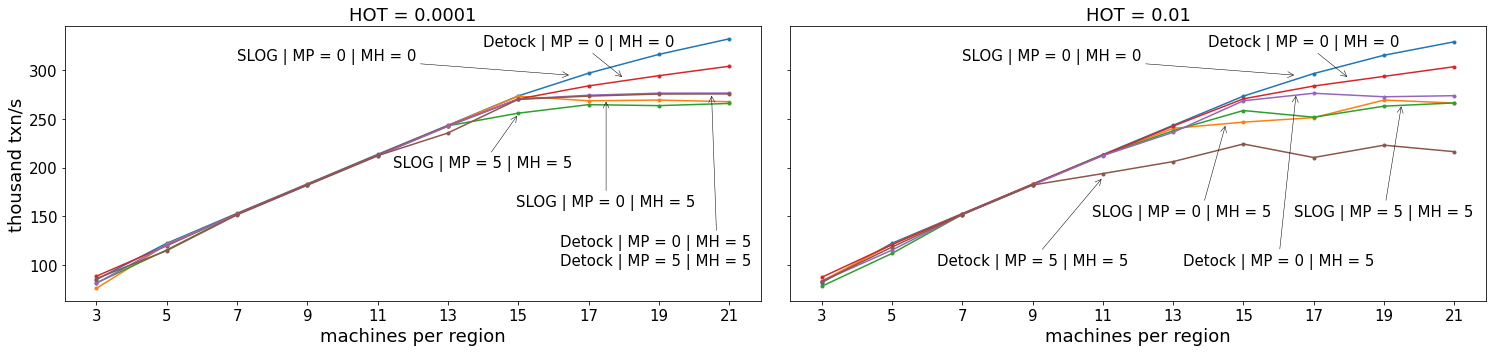

In [8]:
plt.rc('axes', labelsize=18, titlesize=18)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=11)

fig, axes = plt.subplots(1, 2, figsize=(21, 5), sharey=True)

configs = ["baseline", "ddr_ts"]
config_to_label = {
    'baseline': 'SLOG',
    'ddr_ts': 'Detock',
}
mp_pcts = sorted(throughput_df["wl:mp"].unique())
mh_pcts = sorted(throughput_df["wl:mh"].unique())
hots = sorted(throughput_df["wl:hot"].unique(), reverse=True)

for config in configs:
    for i, hot in enumerate(hots):
        for mp in mp_pcts:
            for mh in mh_pcts:
                mask = (
                    (throughput_df["config_name"].str.startswith(config)) &
                    (throughput_df["wl:mp"] == mp) &
                    (throughput_df["wl:mh"] == mh) &
                    (throughput_df["wl:hot"] == hot)
                )
                filtered = throughput_df[mask].sort_values("scale")
                if filtered.empty:
                    continue

                filtered["throughput2"] = filtered["throughput"] / 1000
                label=f'{config_to_label[config]}|MP={mp}|MH={mh}'
                filtered.plot(
                    ax=axes[i],
                    x="scale",
                    y="throughput2",
                    label=label,
                    marker='.',
                    legend=False,
                )

                # if i == 0:
                #     axes[i].set_xlabel(None)
                # else:
                axes[i].set_xlabel("machines per region")
                axes[i].set_title(f"HOT = {1/hot}")
                axes[i].set_ylabel("thousand txn/s")
                axes[i].set_xticks([3, 5, 7, 9, 11, 13, 15, 17, 19, 21])
                axes[i].set_xticklabels([3, 5, 7, 9, 11, 13, 15, 17, 19, 21], rotation=0)

arrowprops = dict(arrowstyle='->', linewidth=0.5)
annotate_font_size = 15

axes[0].annotate('SLOG | MP = 0 | MH = 0', xy=(16.5, 295), xytext=(7, 310),
                 arrowprops=arrowprops, fontsize=annotate_font_size)
axes[0].annotate('Detock | MP = 0 | MH = 0', xy=(18, 292), xytext=(14, 325),
                 arrowprops=arrowprops, fontsize=annotate_font_size)
axes[0].annotate('SLOG | MP = 5 | MH = 5', xy=(15, 255), xytext=(14, 200),
                 arrowprops=arrowprops, ha='center', fontsize=annotate_font_size)
axes[0].annotate('SLOG | MP = 0 | MH = 5', xy=(17.5, 270), xytext=(17.5, 160),
                 arrowprops=arrowprops, ha='center', fontsize=annotate_font_size)
axes[0].annotate('Detock | MP = 0 | MH = 5\nDetock | MP = 5 | MH = 5', xy=(20.5, 276), xytext=(18.9, 100),
                 arrowprops=dict(arrowstyle='->', relpos=(0.82, 1), linewidth=0.5), ha='center', fontsize=annotate_font_size)

axes[1].annotate('SLOG | MP = 0 | MH = 0', xy=(16.5, 295), xytext=(7, 310),
                 arrowprops=arrowprops, fontsize=annotate_font_size)
axes[1].annotate('Detock | MP = 0 | MH = 0', xy=(18, 292), xytext=(14, 325),
                 arrowprops=arrowprops, fontsize=annotate_font_size)
axes[1].annotate('Detock | MP = 5 | MH = 5', xy=(11, 190), xytext=(9, 100),
                 arrowprops=arrowprops, fontsize=annotate_font_size, ha='center')
axes[1].annotate('SLOG | MP = 0 | MH = 5', xy=(14.5, 245), xytext=(13.25, 150),
                 arrowprops=dict(arrowstyle='->', relpos=(0.62, 1), linewidth=0.5), fontsize=annotate_font_size, ha='center')
axes[1].annotate('Detock | MP = 0 | MH = 5', xy=(16.5, 276), xytext=(16, 100),
                 arrowprops=arrowprops, fontsize=annotate_font_size, ha='center')
axes[1].annotate('SLOG | MP = 5 | MH = 5', xy=(19.5, 265), xytext=(19, 150),
                 arrowprops=arrowprops, fontsize=annotate_font_size, ha='center')

fig.tight_layout()
# fig.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', mode='expand', ncol=4)

fig.savefig('output/scalability-2.pdf', bbox_inches='tight')
fig.savefig('output/scalability-2.jpg', bbox_inches='tight')

In [9]:
def deadlock_resolver(spark, prefix):
    events_schema = StructType([
        StructField("time", T.LongType(), False),
        StructField("partition", T.IntegerType(), False),
        StructField("region", T.IntegerType(), False),
        StructField("runtime", T.LongType(), False),
        StructField("unstable_graph_sz", T.IntegerType(), False),
        StructField("stable_graph_sz", T.IntegerType(), False),
        StructField("deadlocks_resolved", T.IntegerType(), False),
        StructField("graph_update_time", T.IntegerType(), False),
    ])

    sdf = spark.read.csv(
        f"{prefix}/server/0-0/deadlock_resolver.csv",
        header=True,
        schema=events_schema
    )\
        .withColumn("unstable_graph_sz", col("unstable_graph_sz") / 1000)\
        .withColumn("stable_graph_sz", col("stable_graph_sz") / 1000)\
        .withColumn("unstable_graph_sz", col("unstable_graph_sz") - col("stable_graph_sz"))\

    return sdf

In [10]:
PREFIX = "file:/home/ctring/data/detock/main/scale/ycsb"

hot10000mh5mp0 = deadlock_resolver(
    spark,
    f"{PREFIX}/ddr_ts-sz19-hot10000mh5mp0"
).where((col("time") >= 1671502868099812874) & (col("time") < 1671502885753598022))

hot10000mh5mp5 = deadlock_resolver(
    spark,
    f"{PREFIX}/ddr_ts-sz19-hot10000mh5mp5"
).where((col("time") >= 1671503036086175654) & (col("time") < 1671503054249851868))

hot100mh5mp0 = deadlock_resolver(
    spark,
    f"{PREFIX}/ddr_ts-sz19-hot100mh5mp0"
).where((col("time") >= 1671503201606482308) & (col("time") < 1671503216306715368))

hot100mh5mp5 = deadlock_resolver(
    spark,
    f"{PREFIX}/ddr_ts-sz19-hot100mh5mp5"
).where((col("time") >= 1671503363768416748) & (col("time") < 1671503388238984680))



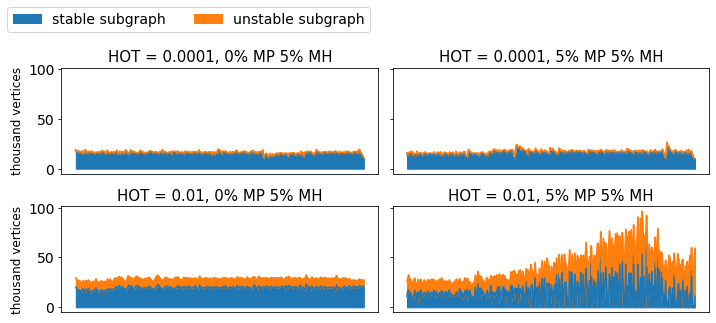

In [11]:
plt.rc('axes', labelsize=12, titlesize=15) 
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)

fig, axes = plt.subplots(2, 2, figsize=(10, 4), sharey=True)

args = dict(y = ["stable_graph_sz", "unstable_graph_sz"], legend=False)

hot10000mh5mp0.toPandas().plot.area(ax=axes[0, 0], label=["stable subgraph", "unstable subgraph"], **args)
hot10000mh5mp5.toPandas().plot.area(ax=axes[0, 1], label=["", ""], **args)
hot100mh5mp0.toPandas().plot.area(ax=axes[1, 0], label=["", ""], **args)
hot100mh5mp5.toPandas().plot.area(ax=axes[1, 1], label=["", ""], **args)

axes[0, 0].set_xticks([])
axes[0, 0].set_ylabel("thousand vertices")
axes[0, 0].set_title("HOT = 0.0001, 0% MP 5% MH")

axes[0, 1].set_xticks([])
axes[0, 1].set_title("HOT = 0.0001, 5% MP 5% MH")

axes[1, 0].set_xticks([])
axes[1, 0].set_ylabel("thousand vertices")
axes[1, 0].set_title("HOT = 0.01, 0% MP 5% MH")

axes[1, 1].set_xticks([])
axes[1, 1].set_title("HOT = 0.01, 5% MP 5% MH")

fig.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', ncol=2)
fig.tight_layout()

fig.savefig('output/graph.pdf', bbox_inches='tight')

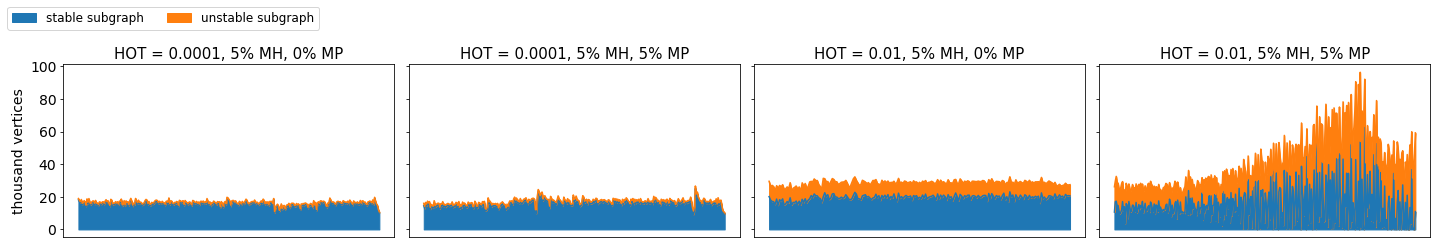

In [12]:
plt.rc('axes', labelsize=14, titlesize=15) 
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=12)

fig, axes = plt.subplots(1, 4, figsize=(20, 3), sharey=True)

args = dict(y = ["stable_graph_sz", "unstable_graph_sz"], legend=False)

hot10000mh5mp0.toPandas().plot.area(ax=axes[0], label=["stable subgraph", "unstable subgraph"], **args)
hot10000mh5mp5.toPandas().plot.area(ax=axes[1], label=["", ""], **args)
hot100mh5mp0.toPandas().plot.area(ax=axes[2], label=["", ""], **args)
hot100mh5mp5.toPandas().plot.area(ax=axes[3], label=["", ""], **args)

axes[0].set_xticks([])
axes[0].set_ylabel("thousand vertices")
axes[0].set_title("HOT = 0.0001, 5% MH, 0% MP")

axes[1].set_xticks([])
axes[1].set_title("HOT = 0.0001, 5% MH, 5% MP")

axes[2].set_xticks([])
axes[2].set_ylabel("thousand vertices")
axes[2].set_title("HOT = 0.01, 5% MH, 0% MP")

axes[3].set_xticks([])
axes[3].set_title("HOT = 0.01, 5% MH, 5% MP")

fig.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', ncol=2)
fig.tight_layout()

fig.savefig('output/graph2.pdf', bbox_inches='tight')